In [1]:
import xarray as xr
from scipy import integrate
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PhotX(object):
    """
    Computes photoionization cross-sections as described in Verner 96
    http://adsabs.harvard.edu/abs/1996ApJ...465..487V
    Original python code from Rabacus implementation
    https://github.com/galtay/rabacus/tree/master/rabacus/atomic/verner/photox
    (Released under GNU GPL3 v.30;
    """

    def __init__(self, datadir=None):
        # Read Verner et al. 1996 photoionization cross-section table
        fname = './verner96_photx.dat'
            
        dat = np.loadtxt(fname, unpack=True)
        self._dat = dat

        # Organize data
        self.Z = self._dat[0]
        self.N = self._dat[1]
        self.Eth = self._dat[2]
        self.Emax = self._dat[3]
        self.E0 = self._dat[4]
        self.sigma0 = self._dat[5] * 1.0e-18
        self.ya = self._dat[6]
        self.P = self._dat[7]
        self.yw = self._dat[8]
        self.y0 = self._dat[9]
        self.y1 = self._dat[10]
        del self._dat

    def get_Eth(self, Z, N, unit='eV'):
        """
        Threshold ionization energy in eV for ions defined by Z and N.

        Parameters
        ----------
        Z : int
            Atomic number (number of protons)
        N : int
            Electron number

        Returns
        -------
        Eth: float
            Threshold ionization energy in eV
        """

        c1 = self.Z == Z
        c2 = self.N == N
        indx = np.where(c1 & c2)
        indx = indx[0][0]
        Eth = self.Eth[indx]

        if unit == 'eV':
            return Eth
        elif unit == 'Angstrom':
            return ((ac.h*ac.c)/(Eth*au.eV)).to('Angstrom').value

    def get_sigma(self, Z, N, E):
        """Returns a photo-ionization cross-section for an ion defined by
        Z and N at energies E in eV.

        Parameters
        ----------
        Z : int
            Atomic number (number of protons)
        N : int
            Electron number (number of electrons)
        E : array of floats
            Calculate cross-section at these energies [eV]

        Returns
        -------
        sigma: array of floats
            Photoionization cross-sections [cm^-2]
        """

        # calculate fit
        c1 = self.Z == Z
        c2 = self.N == N
        indx = np.where(c1 & c2)
        indx = indx[0][0]
        Z = self.Z[indx]
        N = self.N[indx]
        Eth = self.Eth[indx]
        Emax = self.Emax[indx]
        E0 = self.E0[indx]
        sigma0 = self.sigma0[indx]
        ya = self.ya[indx]
        P = self.P[indx]
        yw = self.yw[indx]
        y0 = self.y0[indx]
        y1 = self.y1[indx]

        x = E / E0 - y0
        y = np.sqrt(x*x + y1*y1)

        sigma = sigma0 * ((x-1)*(x-1) + yw*yw) * y**(0.5*P - 5.5) * \
            (1 + np.sqrt(y/ya))**(-P)

        # zero cross-section below threshold
        indx = np.where(E < Eth)
        if indx[0].size > 0:
            sigma[indx] = 0.0

        return sigma

In [3]:
def f_sshld_R13(nH, sigma_pi_mean, T, zeta_pi, fg=0.17, z=0.0):
    """Self-shielding factor by Rahmati+13
    """
    if z < 0.5:
        n0 = 10.0**-2.94
        alpha1 = -3.98
        alpha2 = -1.09
        beta = 1.29
        f = 0.01
    else:
        n0 = 6.73e-3*(sigma_pi_mean/2.49e-18)**(-2.0/3.0)*(T/1e4)**0.17*\
        (zeta_pi.value/1e-12)**(2.0/3.0)*(fg/0.17)**(-1.0/3.0)
        alpha1 = -2.28
        alpha2 = -0.84
        beta = 1.64
        f = 0.2

    x = nH/n0
    return (1.0 - f)*(1.0 + x**beta)**alpha1 + f*(1.0 + x)**alpha2


In [4]:
def read_FG20():
    """Function to read Faucher-Giguère (2020) UV background as functions of nu
    and z

    See : https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.1614F/abstract
    https://galaxies.northwestern.edu/uvb-fg20/

    Returns
    -------
    r : dict

    """
    
    fname = './fg20_spec_lambda.dat'
    with open(fname) as fp:
        ll = fp.readlines()

    # Get redshift
    z = np.array(list(map(lambda zz: np.round(float(zz),3), ll[0].split())))
    zstr = np.array(list(map(lambda zz: str(np.round(float(zz),3)), ll[0].split())))
    nz = len(zstr)

    # Get wavelengths
    wav = []
    for l in ll[1:]:
        wav.append(float(l.split()[0]))

    wav = np.array(wav)*au.angstrom
    nwav = len(wav)

    # Read Jnu
    Jnu = np.zeros((nz,nwav))
    for i,l in enumerate(ll[1:]):
        Jnu[:,i] = np.array(list(map(float, l.split())))[1:]

    r = dict()
    r['nwav'] = nwav
    r['wav'] = wav
    r['nz'] = nz
    r['z'] = z
    r['Jnu'] = Jnu
    r['nu'] = (ac.c/wav).to('Hz').value
    
    da = xr.DataArray(data=r['Jnu'], dims=['z', 'wav'], coords=[r['z'],r['wav']],
                      attrs=dict(description='FG20 UVB', units='ergs/s/cm^2/Hz/sr'))
    r['ds'] = xr.Dataset(dict(Jnu=da))
    conv = (1.0/au.angstrom**2*au.erg/au.s/au.cm**2/au.Hz/au.sr*ac.c).\
        to('erg s-1 cm-2 sr-1 angstrom-1').value

    # Jlambda in unit of erg/s/cm^2/sr/ang
    r['ds']['Jlambda'] = (r['ds']['Jnu']/r['wav']**2)*conv

    # Note that LyC includes X-ray
    idx_FUV = np.logical_and(r['wav'].value < 2000.0, r['wav'].value > 912.0)
    idx_LyC = np.logical_and(r['wav'].value < 912.0, r['wav'].value > 0.0)
    idx_Xray = np.logical_and(r['wav'].value < 100.0, r['wav'].value > 0.0)
    
    r['J_FUV'] = -integrate.trapz(r['nu'][idx_FUV]*r['ds']['Jnu'][:,idx_FUV],
                                       x=np.log(r['nu'][idx_FUV]))
    r['J_LyC'] = -integrate.trapz(r['nu'][idx_LyC]*r['ds']['Jnu'][:,idx_LyC],
                                  x=np.log(r['nu'][idx_LyC]))
    r['J_Xray'] = -integrate.trapz(r['nu'][idx_Xray]*r['ds']['Jnu'][:,idx_Xray],
                                   x=np.log(r['nu'][idx_Xray]))
    r['idx_FUV'] = idx_FUV
    r['idx_LyC'] = idx_LyC
    r['idx_Xray'] = idx_Xray

    E_LyC = (ac.h*r['nu'][idx_LyC]*au.Hz).to('eV').value
    E_Xray = (ac.h*r['nu'][idx_Xray]*au.Hz).to('eV').value
    
    px = PhotX()
    Eth_H = px.get_Eth(1,1)
    sigma_pi_H_LyC = px.get_sigma(1,1,E_LyC)
    sigma_pi_H_Xray = px.get_sigma(1,1,E_Xray)

    # Photoionization rate
    # $\zeta_{\rm pi} = \int \frac{4\pi J_{\nu}}{h\nu} \sigma_{\rm pi} d\nu$
    
    # $\mathcal{I}_{\rm phot} = n_{\rm HI}\int_{\nu_0}^{\infty}
    # \frac{4\pi J_{\nu}}{h\nu} \sigma_{\rm pi,\nu} d\nu = n_{\rm HI} \zeta_{\rm pi,H}$

    # Photoheating rate
    # $n_{\rm HI} q_{\rm pi,H}\zeta_{\rm pi,H} = n_{\rm H}\Gamma_{\rm pi} =
    # n_{\rm HI}\int_{\nu_0}^{\infty} \frac{4\pi J_{\nu}}{h\nu} \sigma_{\rm pi,\nu}(h\nu - h\nu_0) d\nu$
    
    zeta_pi_H = -integrate.trapz(4.0*np.pi*r['ds']['Jnu'][:,idx_LyC]*\
                                 sigma_pi_H_LyC/(E_LyC*au.eV).cgs.value,
                                 x=r['nu'][idx_LyC])
    q_zeta_pi_H = -integrate.trapz(4.0*np.pi*r['ds']['Jnu'][:,idx_LyC]*\
                                   sigma_pi_H_LyC/(E_LyC*au.eV).cgs.value*\
                                   (E_LyC*au.eV - Eth_H*au.eV).cgs.value,
                                   x=r['nu'][idx_LyC])
    q_pi_H = (q_zeta_pi_H/zeta_pi_H*au.erg).to('eV')
    sigma_mean_pi_H = -zeta_pi_H/(integrate.trapz(4.0*np.pi*r['ds']['Jnu'][:,idx_LyC]/\
                                                  (E_LyC*au.eV).cgs.value,
                                                  x=r['nu'][idx_LyC]))

    zeta_pi_H_Xray = -integrate.trapz(4.0*np.pi*r['ds']['Jnu'][:,idx_Xray]*\
                                      sigma_pi_H_Xray/(E_Xray*au.eV).cgs.value,
                                      x=r['nu'][idx_Xray])
    
    # Save J as dataset
    r['ds_int'] = xr.Dataset(data_vars=dict(J_LyC=('z',r['J_LyC']),
                                            J_FUV=('z',r['J_FUV']),
                                            zeta_pi_H=('z',zeta_pi_H),
                                            zeta_pi_H_Xray=('z',zeta_pi_H_Xray),
                                            q_zeta_pi_H=('z',q_zeta_pi_H),
                                            q_pi_H=('z',q_pi_H),
                                            sigma_mean_pi_H=('z',sigma_mean_pi_H),
                                            ),
                             coords=dict(z=r['z']))
    
    return r


class CoolRosen95(object):
    """Rosen & Bregman (1995) cooling function
    """
    
    def __init__(self):
        
        self.T = np.logspace(np.log10(300.0001),8,1000)
        self.T_ext = np.logspace(np.log10(10.0),8,1000)
    
    @staticmethod
    def LambdaRosen95(T):
        """
        Original definition (zero below 300 K)
        """
        Lambda = np.where(np.logical_and(T > 3e2, T < 2e3),
                          2.2380e-32*T**2.0, 0.0) + \
                 np.where(np.logical_and(T >= 2e3, T < 8e3),
                         1.0012e-30*T**1.5, 0.0) + \
                 np.where(np.logical_and(T >= 8e3, T < 1e5),
                          4.6240e-36*T**2.867, 0.0) + \
                 np.where(np.logical_and(T >= 1e5, T < 4e7),
                          1.6700e-18*T**-0.65, 0.0) + \
                 np.where(T >= 4e7, 3.2217e-27*T**0.5, 0.0)
        return Lambda
    
    @staticmethod
    def LambdaRosen95_ext(T):
        """
        Extrapolation in log-log space below 300 K
        """
        Lambda = np.where(np.logical_and(T > 1.0, T < 2e3),
                          2.2380e-32*T**2.0, 0.0) + \
                 np.where(np.logical_and(T >= 2e3, T < 8e3),
                         1.0012e-30*T**1.5, 0.0) + \
                 np.where(np.logical_and(T >= 8e3, T < 1e5),
                          4.6240e-36*T**2.867, 0.0) + \
                 np.where(np.logical_and(T >= 1e5, T < 4e7),
                          1.6700e-18*T**-0.65, 0.0) + \
                 np.where(T >= 4e7, 3.2217e-27*T**0.5, 0.0)
        
        return Lambda

In [5]:
def get_charge_param(nH, T, xe, chi_PE, phi=1.0):
    # Charging parameter
    # (WD01 does not recommend using their eqaution for x < 100)
    # return np.maximum(1.7*chi_PE*np.sqrt(T)/(xe*nH*phi), 100.0)
    return 1.7*chi_PE*np.sqrt(T)/(xe*nH*phi) + 50.0

def heatCR(nH, xe, xHI, xH2, xi_CR):

    eV_cgs = (1.0*au.eV).cgs.value
    qHI = (6.5 + 26.4*np.sqrt(xe / (xe + 0.07)))*eV_cgs

    # Heating rate per ionization in molecular region
    # See Appendix B in Krumholz 2014 (Despotic)
    log_nH = np.log10(nH)
    qH2 = np.zeros_like(nH)
    qH2 = np.where(log_nH < 2.0, 10.0*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 2.0, log_nH < 4.0),
                   (10 + 3*(log_nH - 2.0)*0.5)*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 4.0, log_nH < 7.0),
                   (13 + 4*(log_nH - 4.0)/3)*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 7.0, log_nH < 10.0),
                   (17 + (log_nH - 7.0)/3)*eV_cgs, 0.0) + \
          np.where(log_nH >= 10.0, 18.0*eV_cgs, 0.0)

    return xi_CR*(xHI*qHI + 2.0*xH2*qH2)

def heatPE(nH, T, xe, Z_d, chi_PE):
    # Weingartner & Draine (2001) Table 2
    # Rv = 3.1, bC=4.0, distribution A, ISRF
    CPE_ = np.array([5.22, 2.25, 0.04996, 0.00430, 0.147, 0.431, 0.692])
    x = get_charge_param(nH, T, xe, chi_PE)
    eps = (CPE_[0] + CPE_[1]*np.power(T, CPE_[4]))/ \
        (1. + CPE_[2]*np.power(x, CPE_[5])*(1. + CPE_[3]*np.power(x, CPE_[6])))

    return 1.7e-26*chi_PE*Z_d*eps

def heatCR(nH, xe, xHI, xH2, xi_CR):

    eV_cgs = (1.0*au.eV).cgs.value
    qHI = (6.5 + 26.4*np.sqrt(xe / (xe + 0.07)))*eV_cgs

    # Heating rate per ionization in molecular region
    # See Appendix B in Krumholz 2014 (Despotic)
    log_nH = np.log10(nH)
    qH2 = np.zeros_like(nH)
    qH2 = np.where(log_nH < 2.0, 10.0*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 2.0, log_nH < 4.0),
                   (10 + 3*(log_nH - 2.0)*0.5)*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 4.0, log_nH < 7.0),
                   (13 + 4*(log_nH - 4.0)/3)*eV_cgs, 0.0) + \
          np.where(np.logical_and(log_nH >= 7.0, log_nH < 10.0),
                   (17 + (log_nH - 7.0)/3)*eV_cgs, 0.0) + \
          np.where(log_nH >= 10.0, 18.0*eV_cgs, 0.0)

    return xi_CR*(xHI*qHI + 2.0*xH2*qH2)

def coeff_alpha_rr_H(T):
    """Gong+17's fit to Ferland+92 radiative recombination
    """
    Tinv = 1/T
    bb = 315614.0*Tinv
    cc = 115188.0*Tinv
    dd = 1.0 + np.power(cc, 0.407)
    alpha_rr = 2.753e-14*np.power(bb, 1.5)*np.power(dd, -2.242)

    return alpha_rr

def coeff_kcoll_H(T):
    """Collisional ionization rate coeff. (Gong+17)
    """
    lnT = np.log(T)
    lnTe = np.log(T*8.6173e-5)
    k_coll = np.where(T > 3.0e3,
                np.exp((-3.271396786e1+ (1.35365560e1 + (- 5.73932875 + (1.56315498
                      + (- 2.877056e-1 + (3.48255977e-2 + (-2.63197617e-3
                      + (1.11954395e-4 + (-2.03914985e-6)
                         *lnTe)*lnTe)*lnTe)*lnTe)*lnTe)*lnTe)*lnTe)*lnTe)),
                      0.0)
    return k_coll

def get_xn_eq(T, nH, zeta_pi=0.0, zeta_cr=0.0, coll_ion=True):
    """Function to compute equilibrium neutral fraction xHI = 1 - xHII
    e.g., Appendix C3 in Altay & Theuns (2013)
    """
    
    T = np.atleast_1d(T)
    nH = np.atleast_1d(nH)
    if coll_ion:
        zeta_ci = nH*coeff_kcoll_H(T)
    else:
        zeta_ci = 0.0
        
    zeta_rec = nH*coeff_alpha_rr_H(T)

    aa = 1.0 + zeta_ci/zeta_rec
    bb = -(2.0 + (zeta_pi + zeta_cr + zeta_ci)/zeta_rec)
    x = -bb/(2.0*aa)*(1 - (np.lib.scimath.sqrt(1 - 4.0*aa/bb**2)).real)
    
    return x

In [6]:
def get_equil(f_Lambda, z=0.0, manual=True, Gamma_pe0=None, 
              heating_pi_UVB=True, heating_pe=True, heating_cr=False,
              sshld=False, chi_PE=1.0, Zd=1.0, xi_cr=0.0, coll_ion=True):
    """
    Function to compute equilibrium T and xHI
    f_Lambda(T): cooling function
    z: redshift (UVB; use zero)
    manual: set heating, ionization rate manually from FG21 table
    Gamma_pe0: a constant value of PE heating rate per H (erg/s) (used if not None)
    heating_pi_UVB: photionziation heating
    heating_pe: pe heating by ISRF
    heating_cr: cr heating
    sshld: UVB attenuation (Rahmati+13)
    chi_PE: ISRF (in Draine's unit)
    Zd: dust abundance
    xi_cr: primary cr ionization rate (1/s)
    coll_ion: turn on collisional ionization
    """
    

    # Read FG UV Background
    r = read_FG20()

    if not manual:
        zeta_pi_H = float(r['ds_int']['zeta_pi_H'].sel(z=z, method='nearest'))# /au.s
        q_pi_H = float(r['ds_int']['q_pi_H'].sel(z=z, method='nearest'))# *au.erg
        q_zeta_pi_H = float(r['ds_int']['q_zeta_pi_H'].sel(z=z, method='nearest'))# *au.erg/au.s
    else:
        if z != 0:
            raise ValueError("z!=0 not supported")

        # Values from Table D1 in FG21
        zeta_pi_H = 3.62e-14 # /au.s
        q_zeta_pi_H = 2.03e-25 # *au.erg/au.s

    # Table does not provide this information
    sigma_pi_H = float(r['ds_int']['sigma_mean_pi_H'].sel(z=z,method='nearest'))
    print('redshift, zeta_pi, q_pi*zeta_pi, sigma_pi:',z,zeta_pi_H,q_zeta_pi_H,sigma_pi_H)
    
    def f_net_cool(T, nH):
        # WD PE heating with xe_eq from UV background
        if sshld:
            f_sshld = f_sshld_R13(nH, sigma_pi_H, T, zeta_pi_H)
        else:
            f_sshld = 1.0

        xn = get_xn_eq(T, nH, f_sshld*zeta_pi_H, 1.5*xi_cr, coll_ion=coll_ion)
        
        Gamma_tot = 0.0
        if heating_pi_UVB:
            Gamma_tot += f_sshld*q_zeta_pi_H*xn
        if heating_pe:
            if Gamma_pe0 is not None:
                Gamma_tot += Gamma_pe0
            else:
                Gamma_tot += heatPE(nH, T, 1.0 - xn, Zd, chi_PE)
        if heating_cr:
            Gamma_tot += heatCR(nH, 1.0-xn, xn, 0.0, xi_cr)
        
        return Gamma_tot - nH*f_Lambda(T)
    
    nH = np.logspace(-2,3,500)
    T = np.zeros_like(nH)
    root_result = []

    for i,nH_ in enumerate(nH):
        T[i], root_result_ = brentq(f_net_cool, 1e0, 1e5, args=(nH_,), full_output=True)
        root_result.append(root_result_)
        if not root_result_.converged:
            print('Not converged nH Teq',nH_,T[i],root_result_)
        
    if sshld:
        f_sshld = f_sshld_R13(nH, sigma_pi_H, T, zeta_pi_H)
    else:
        f_sshld = 1.0
    
    if Gamma_pe0 is None:
        xn = get_xn_eq(T, nH, f_sshld*zeta_pi_H, 1.5*xi_cr, coll_ion=coll_ion)
    else:
        xn = np.repeat(1.0,len(T))

    if heating_pe:
        if Gamma_pe0 is None:
            Gamma_pe = heatPE(nH, T, 1.0 - xn, Zd, chi_PE)
        else:
            Gamma_pe = np.repeat(Gamma_pe0,len(T))
    else:
        Gamma_pe = np.repeat(0.0,len(T))
        
    if heating_pi_UVB:
        Gamma_pi_UVB = f_sshld*q_zeta_pi_H*xn
    else:
        Gamma_pi_UVB = np.repeat(0.0,len(T))
    
    if heating_cr:
        Gamma_cr = heatCR(nH, 1.0-xn, xn, 0.0, xi_cr)
    else:
        Gamma_cr = np.repeat(0.0,len(T))
    
    res = dict(nH=nH, T=T, xn=xn, f_sshld=f_sshld, 
               heating_pe=heating_pe, heating_pi_UVB=heating_pi_UVB, 
               heating_cr=heating_cr, Gamma_pe=Gamma_pe,
               Gamma_pi_UVB=Gamma_pi_UVB, Gamma_cr=Gamma_cr,
               root_result=root_result)
    
    return res

In [7]:
cr = CoolRosen95()
f_rosen95 = interp1d(cr.T_ext, cr.LambdaRosen95_ext(cr.T_ext),
                     bounds_error=False, fill_value='extrapolate')

redshift, zeta_pi, q_pi*zeta_pi, sigma_pi: 0.0 3.62e-14 2.03e-25 2.795435674290946e-18


/Users/jgkim/miniconda3/envs/pyathena/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


[1e-05, 2.0, Text(0, 0.5, '$x_{\\rm e} = n_{\\rm e}/n$')]

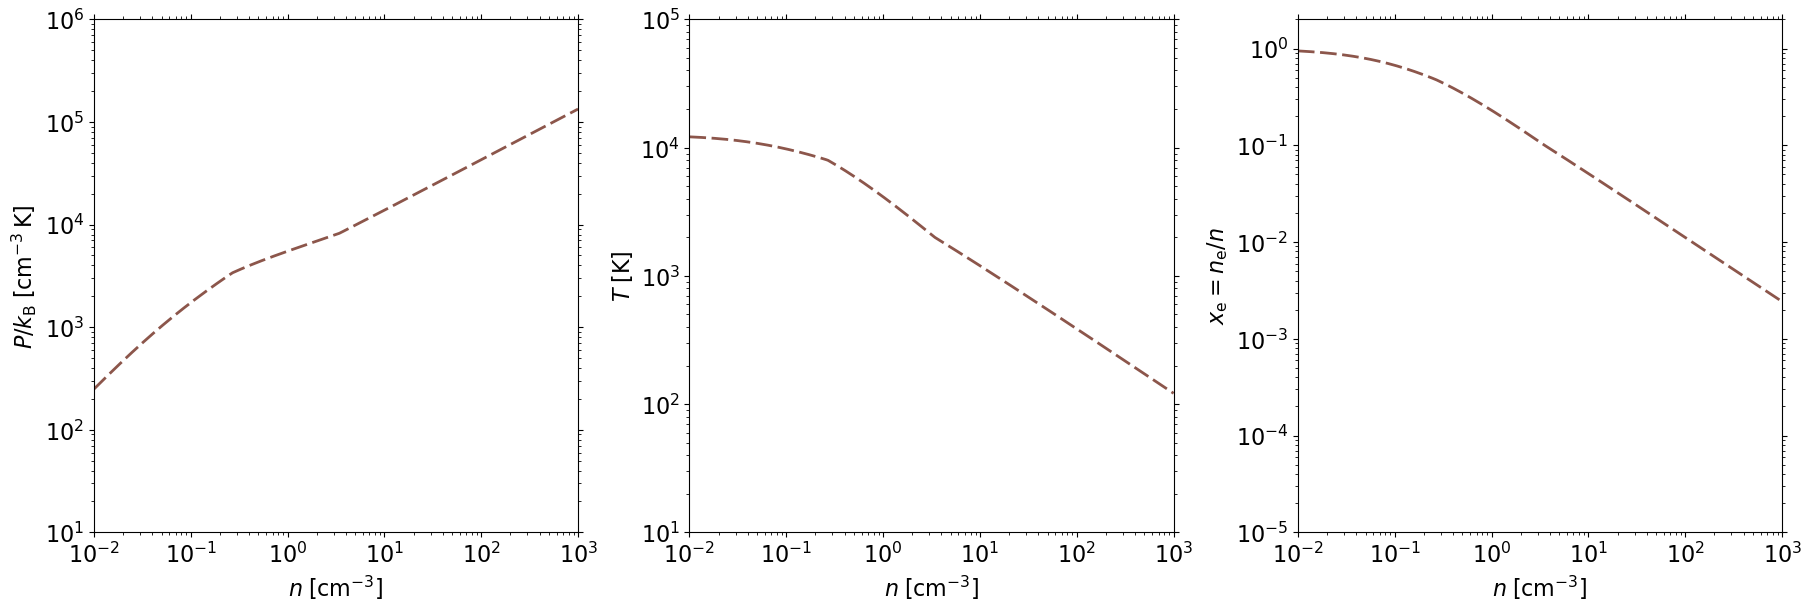

In [8]:
fig,axes = plt.subplots(1,3,figsize=(18,6),constrained_layout=True)

# no sshld, yes pi, no pe, no cr
plt_kwargs=dict(lw=2.0, c='tab:brown', dashes=[6,2], ls='--')
rr = get_equil(f_rosen95, z=0.0, manual=True, Gamma_pe0=None,
               heating_pi_UVB=True, heating_pe=True, heating_cr=False, sshld=False,
               chi_PE=1.0, Zd=1.0, xi_cr=0.0, coll_ion=True)
axes[0].loglog(rr['nH'], (2.1 - rr['xn'])*rr['nH']*rr['T'], label='no shld', **plt_kwargs)
axes[1].loglog(rr['nH'], rr['T'], **plt_kwargs)
axes[2].loglog(rr['nH'], 1-rr['xn'], **plt_kwargs)

plt.setp(axes, xlim=(1e-2,1e3), xlabel=r'$n\;[{\rm cm}^{-3}]$')
plt.setp(axes[0], ylim=(1e1,1e6), ylabel=r'$P/k_{\rm B}\;[{\rm cm}^{-3}\,{\rm K}]$')
plt.setp(axes[1], ylim=(1e1,1e5), ylabel=r'$T\;[{\rm K}]$')
plt.setp(axes[2], ylim=(1e-5,2e0), ylabel=r'$x_{\rm e} = n_{\rm e}/n$')

(5e-29, 1e-24)

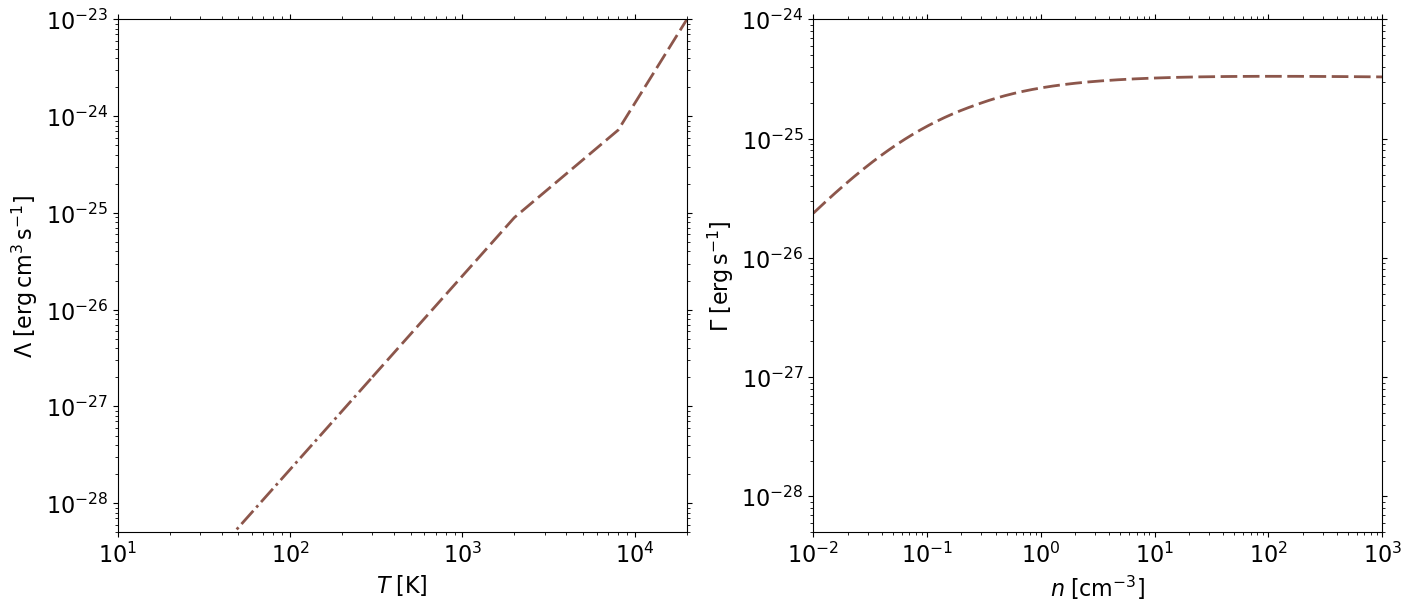

In [9]:
fig, axes = plt.subplots(1,2, figsize=(14,6), gridspec_kw=dict(hspace=1.0), constrained_layout=True)

axes[0].loglog(cr.T, cr.LambdaRosen95(cr.T), label='Rosen+95/RAMSES', **plt_kwargs)
# Plot the low-T range  T < 300K
plt_kwargs_=dict(lw=2.0, c='tab:brown', ls='-.')
idx = np.where(cr.T_ext <= 300.0)[0]
axes[0].loglog(cr.T_ext[idx], cr.LambdaRosen95_ext(cr.T_ext[idx]),
               label='Rosen+95/RAMSES', **plt_kwargs_)
axes[1].loglog(rr['nH'],(rr['Gamma_pe']+rr['Gamma_pi_UVB']+rr['Gamma_cr']), **plt_kwargs)

axes[0].set_xlabel(r'$T\;[{\rm K}]$')
axes[1].set_xlabel(r'$n\;[{\rm cm}^{-3}]$')
axes[0].set_ylabel(r'$\Lambda\;[{\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}]$')
axes[1].set_ylabel(r'$\Gamma\;[{\rm erg}\,{\rm s}^{-1}]$')
axes[0].set_xlim(10,2e4)
axes[0].set_ylim(5e-29,1e-23)
axes[1].set_xlim(1e-2,1e3)
axes[1].set_ylim(5e-29,1e-24)
